# Project :  Predicting Used Car Prices in Virginia using Machine Learning

### 1. Data Introduce
### 1.1 Purpose : Predict SalePrice
### 1.2 Data set:
- Collect Used Car data from Cars.com 
- Total Data : It consists of 14 variables and 1460 Used Car data

### 1.3 Evaluation
   > - Root-Mean-Squared-Error (RMSE)  

$$
RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}
$$



### 1. Exploring the Data
Let's start with importing the necessary libaries, reading in the data and checking out the dataset.

In [ ]:
import pandas as pd
import numpy as np
import re
import pymysql, pickle
import matplotlib.pyplot as plt
from collections import Counter

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)

def load_data():

    # Read Password

    pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
    host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 
    
    # AWS MySql Connection Info
    db = pymysql.connect(
        host = host_,
        user = "root",
        password = pw,
        db = "usedcar",
        charset='utf8',
    )

    SQL_QUERY = """
        SELECT *
        FROM usedcar;
    """

    train = pd.read_sql(SQL_QUERY, db)
    pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))
    
    return train

pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 

# AWS MySql Connection Info
db = pymysql.connect(
    host = host_,
    user = "root",
    password = pw,
    db = "usedcar",
    charset='utf8',
)

SQL_QUERY = """
    SELECT *
    FROM usedcar;
"""

train = pd.read_sql(SQL_QUERY, db)
pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))

## 1. Load data

The stored data retrieved through data crawling is loaded into a DataFrame

In [251]:
train = pickle.load(open('./Flask/pickle/database.pkl', 'rb')) 

### (1) Check data

In [252]:
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 46924 rows and 16 columns


#### Comments :
There are 46924 instances of data and its number of attributes equals 16

### (2) Check data type

In [253]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46924 entries, 0 to 46923
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           46924 non-null  int64 
 1   ID              46924 non-null  object
 2   Year            46924 non-null  int64 
 3   Brand           46924 non-null  object
 4   Model           46924 non-null  object
 5   Mileage         46924 non-null  int64 
 6   Bodystyle       46545 non-null  object
 7   Dealer          45700 non-null  object
 8   Exterior Color  46924 non-null  object
 9   Interior Color  46923 non-null  object
 10  Drivetrain      46924 non-null  object
 11  MPG             46924 non-null  object
 12  Fuel Type       46924 non-null  object
 13  Transmission    46924 non-null  object
 14  Engine          46924 non-null  object
 15  Price           46924 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 5.7+ MB


#### Comments :

Out of a total of 16 columns, 4 are of type int64, while the remaining 12 are of type object. The total number of data entries is 46924, and it can be observed that Bodystyle, Dealer, and Interior Color have some missing values.

### (3) Status of Train data

In [254]:
train.describe()

,index,Year,Mileage,Price
count,46924.000000,46924.000000,46924.000000,4.692400e+04
mean,3205.419657,2016.172769,62118.963707,4.035456e+04
std,2293.697892,7.413188,50519.289211,7.761011e+04
min,0.000000,1937.000000,0.000000,2.432000e+03
25%,1248.000000,2014.000000,22556.000000,1.476800e+04
50%,2809.000000,2018.000000,50650.000000,2.500000e+04
75%,4835.000000,2021.000000,91468.000000,4.064900e+04
max,12424.000000,2024.000000,369197.000000,3.599000e+06


#### Comments :

There are no missing data in the numerical columns, and the oldest car was produced in 1937. The lowest price for a vehicle can be confirmed to be around $2,432.

## 2. Data Cleaning

### (1) Remove duplicate data using ID

The ID column is a combination of Year, Brand, Model, Mileage, and Dealer and was created to delete duplicate data. Now delete duplicate data using this column data

In [242]:
train = train.drop_duplicates(['ID']).reset_index(drop=True)
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 4898 rows and 16 columns


#### Comments :

All duplicate data was deleted, leaving only 4898 out of 46924 data.
Since small data will affect performance when creating machine learning models later, I need to think about how to solve this problem.

### (2) Check the missing values

In [240]:
import missingno as msno 

<Axes: >

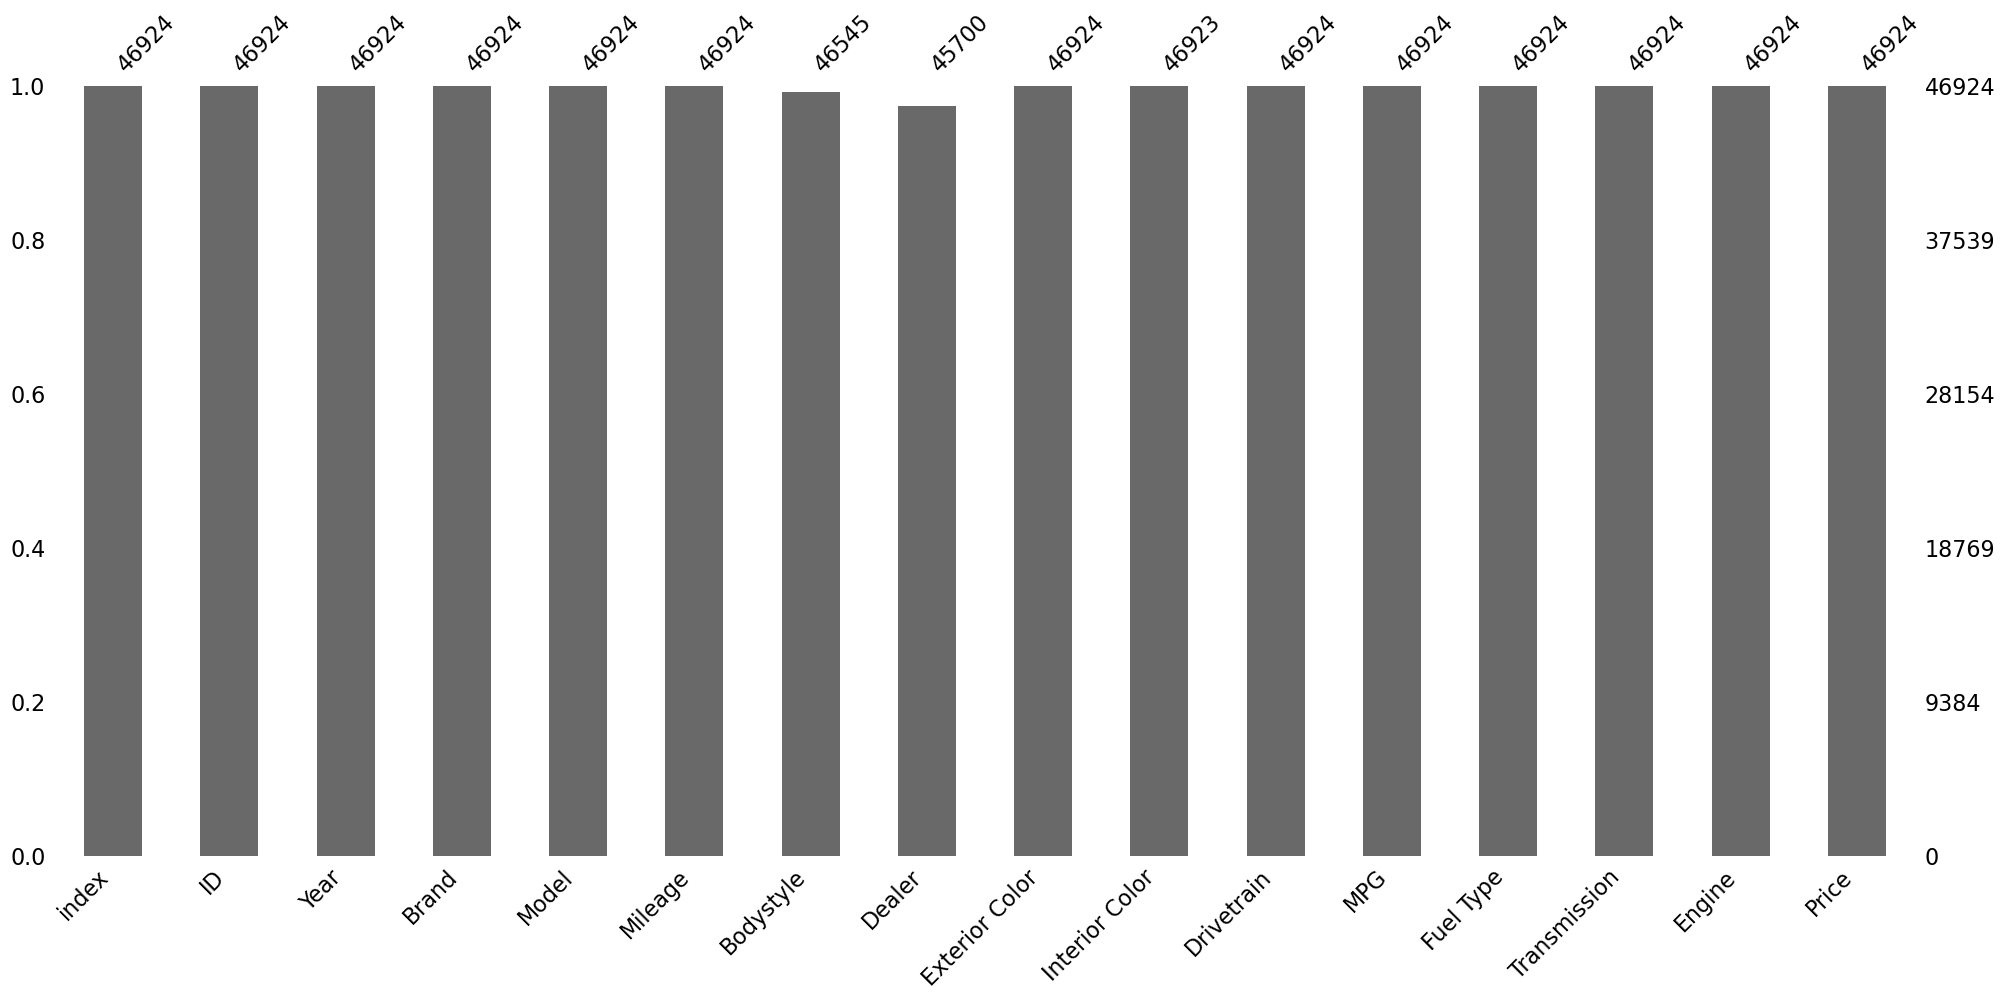

In [241]:
#Visualize missing values
msno.bar(train)

#### Comments :

It has been confirmed that there is missing data in Bodystyle and Dealer Interior Color, and it is necessary to add appropriate data in the future.

### (3) Delete unnecessary columns

Need to remove the unnecessary index column used along with the ID for deleting duplicate data during data analysis. The index was created when the data was stored in MySQL, and during the process of loading the data into the DataFrame, the index was created as a separate column in the DataFrame. This information is irrelevant to the data and needs to be removed.

In [243]:
train = train.drop(columns=['ID','index']).reset_index(drop=True)

### (4) Find and remove the outliers

The outliers could compromise the predictive power of the model. Using the quartile method, outliers in the prices of used cars were identified and removed.

In [244]:
import pandas as pd

# Identifying outliers
Q1 = train['Price'].quantile(0.25)
Q3 = train['Price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

count_lower_bound = len(train[train['Price'] < lower_bound])
print("Lower Bound Price : ", lower_bound)
print("Number of cars priced below lower_bound :", count_lower_bound)
print("")


count_upper_bound = len(train[train['Price'] > upper_bound])
print("Upper Bound Price : ", upper_bound)
print("Number of cars priced above upper_bound :", count_upper_bound)
print("")

outliers = train[(train['Price'] < lower_bound) | (train['Price'] > upper_bound)]
outlier_prices = outliers['Price']
print("Number of outliers:", len(outlier_prices))


# Delete rows containing outliers.
train = train[~train['Price'].isin(outlier_prices)]

# Check the data after deletion.
print("Total number of rows after removing outliers:", len(train))

Lower Bound Price :  -20593.5
Number of cars priced below lower_bound : 0

Upper Bound Price :  76722.5
Number of cars priced above upper_bound : 419

Number of outliers: 419
Total number of rows after removing outliers: 4479


## 3. Exploratory Data Analysis (EDA)

### (1) An examination of price trend

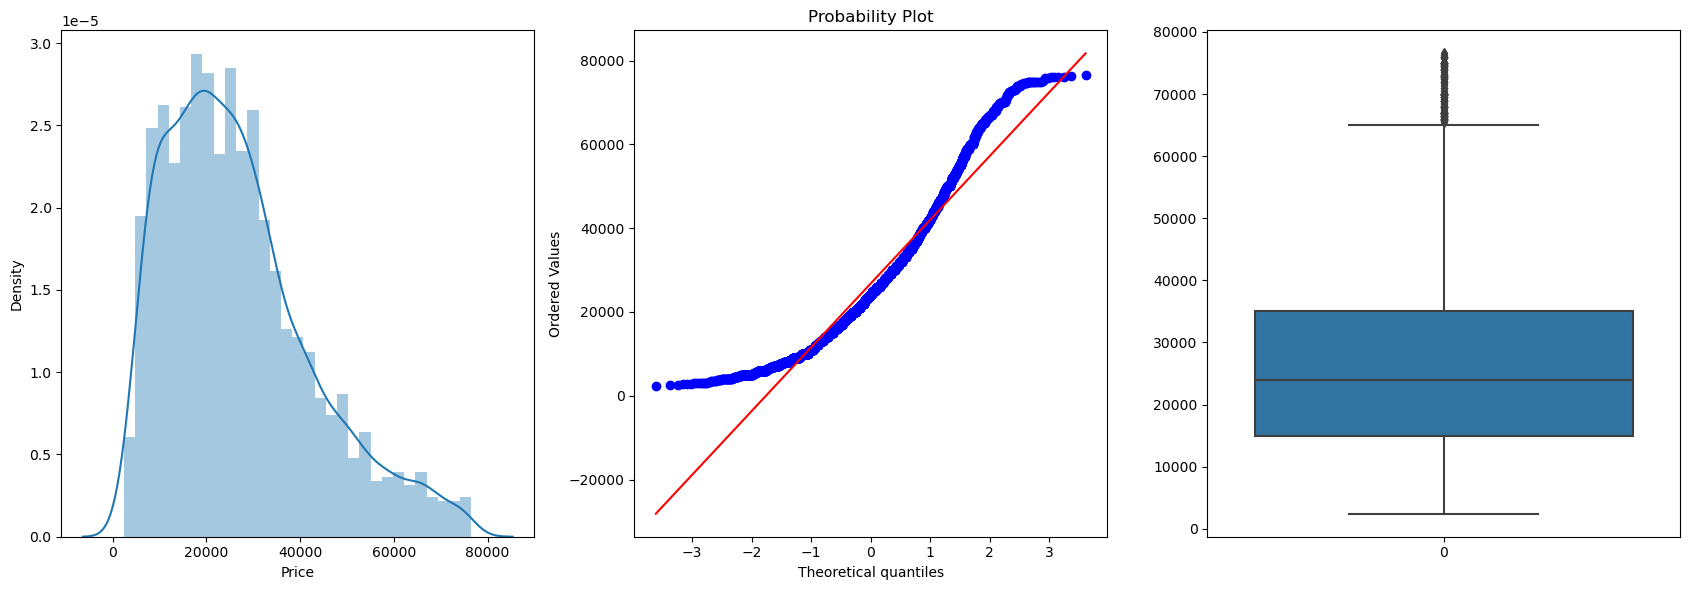

count     4479.000000
mean     26779.188212
std      15714.309215
min       2432.000000
25%      14950.000000
50%      23998.000000
75%      34995.000000
max      76557.000000
Name: Price, dtype: float64 

Skewness: 0.888484
Kurtosis: 0.377538


In [245]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["Price"])

plt.subplot(132)
stats.probplot(train["Price"], plot=plt)

plt.subplot(133)
sns.boxplot(train["Price"])
plt.tight_layout()
plt.show()

print(train["Price"].describe(),"\n")

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

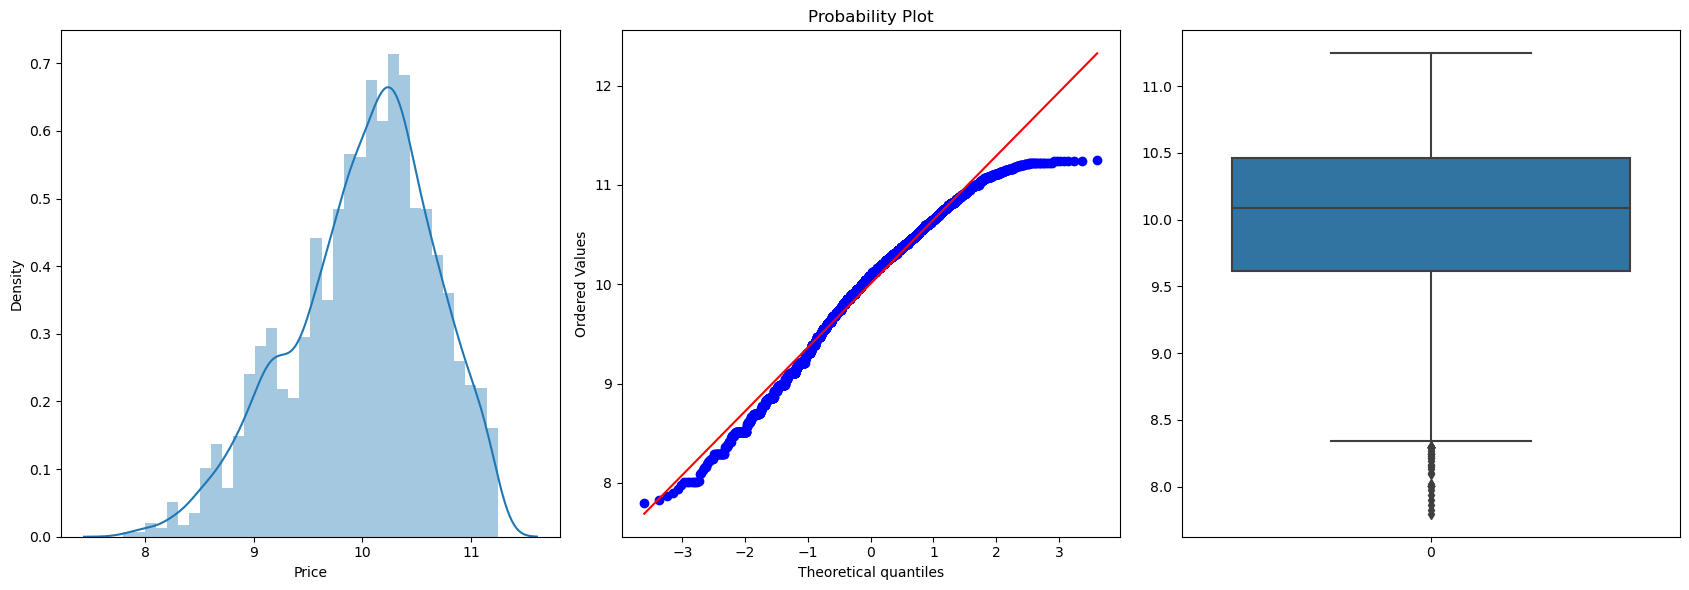

In [249]:
nomalized_Price = np.log1p(train["Price"])

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(nomalized_Price)

plt.subplot(132)
stats.probplot(nomalized_Price, plot=plt)

plt.subplot(133)
sns.boxplot(nomalized_Price)
plt.tight_layout()
plt.show()

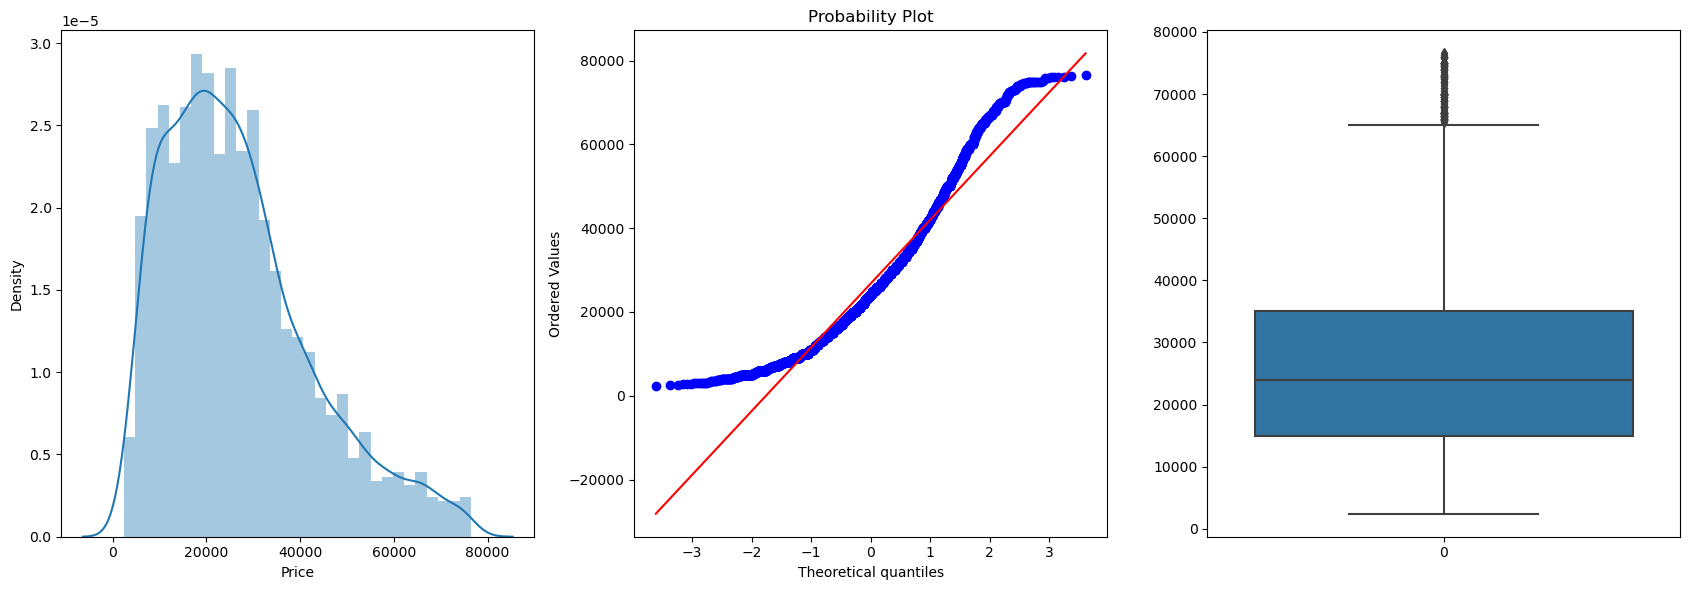

count     4479.000000
mean     26779.188212
std      15714.309215
min       2432.000000
25%      14950.000000
50%      23998.000000
75%      34995.000000
max      76557.000000
Name: Price, dtype: float64 

Skewness: 0.888484
Kurtosis: 0.377538


In [248]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["Price"])

plt.subplot(132)
stats.probplot(train["Price"], plot=plt)

plt.subplot(133)
sns.boxplot(train["Price"])
plt.tight_layout()
plt.show()

print(train["Price"].describe(),"\n")

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

In [159]:
train_data_subset = train.iloc[[1, 5, 6]]
print(train_data_subset)

   index                                                 ID  Year   Brand  \
1      7  2023toyotaprius2947cowboydodgechryslerjeeprams...  2023  toyota   
5     14  2021lexusgx_46061418mercedes-benzofstatecolleg...  2021   lexus   
6     17  2015bmw65097289primeautoimportsdeepseabluemeta...  2015     bmw   

    Model  Mileage  Bodystyle                          Dealer  \
1   prius     2947  hatchback  cowboy dodge chrysler jeep ram   
5  gx_460    61418        suv  mercedes-benz of state college   
6     650    97289      sedan              prime auto imports   

           Exterior Color Interior Color   Drivetrain    MPG Fuel Type  \
1                  silver     light gray  front-wheel  57–56  gasoline   
5          nightfall mica          black   four-wheel  15–19  gasoline   
6  deep sea blue metallic    ivory white    all-wheel  16–24  gasoline   

  Transmission                                             Engine  Price  
1     variable  2l i-4 port/direct injection, dohc, vvt-i 

In [192]:
def process_engine_text(text):
    # 모든 스페이스 이전의 문자만 추출
    index = text.find(' ')
    if index != -1:
        return text[:index]
    else:
        return text
    
train['Engine'] = train['Engine'].apply(process_engine_text)
train['Dealer'] = train['Dealer'].str.replace('[\,\<,\>,\/,\[\]\-\s]', '', regex=True)
train['Interior Color'] = train['Interior Color'].str.replace('[\,\<,\>,\/,\[\]\-\s]', '', regex=True)
train['Exterior Color'] = train['Exterior Color'].str.replace('[\,\<,\>,\/,\[\]\-\s]', '', regex=True)
train

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2021,volkswagen,tiguan,23626,suv,carmaxjensenbeachofferingexpresspickupandhomed...,platinumgraymetallic,black,front-wheel,23–29,gasoline,8-speed automatic,2.0l,23998
1,2023,toyota,prius,2947,hatchback,cowboydodgechryslerjeepram,silver,lightgray,front-wheel,57–56,gasoline,variable,2l,33217
2,2017,hyundai,accent,97675,sedan,freedomautosales,centurywhite,beige,front-wheel,26–36,gasoline,6-speed automatic,1.6l,9497
3,2016,dodge,dart,107671,sedan,caroneauto,blue,gray,front-wheel,25–36,gasoline,6-speed automatic,2.0l,6941
5,2021,lexus,gx_460,61418,suv,mercedesbenzofstatecollege,nightfallmica,black,four-wheel,15–19,gasoline,automatic,4.6l,37999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,2023,gmc,terrain,20267,suv,allamericanchryslerdodgejeepramofmidland,ebonytwilightmetallic,jetblack,all-wheel,24–28,gasoline,9-speed automatic,1.5l,27931
4894,2021,bmw,m235_gran_coupe,38704,sedan,donthorntonvolkswagenoftulsa,mineralgraymetallic,mocha,all-wheel,23–32,gasoline,8-speed automatic,2.0l,33362
4895,2017,mazda,mx_5_miata,76051,convertible,taylorautosalesinc,soulredmetallic,46730,rear-wheel,26–35,gasoline,manual,skyactiv-g,18995
4896,2015,buick,lacrosse,134401,sedan,mattbowersnissaneasternshore,champagnesilver,lightneutral,front-wheel,18–28,e85 flex fuel,6-speed automatic,3.6l,12497


KeyError: "['ID', 'index'] not found in axis"

def remove_rows_with_special_characters(df):
    special_characters = [',', '[', ']', '<']
    for index, row in df.iterrows():
        for column in df.columns:
            if column != 'ID' or 'Dealer':
            
    

In [196]:
import re

def remove_rows_with_special_characters(df):
    special_characters = [',', '[', ']', '<']
    rows_to_remove = []
    for index, row in df.iterrows():
        for column in df.columns:
            if column != 'ID' or 'Dealer':
                for char in special_characters:
                    if re.search(fr'\{char}', str(row[column])):
                        rows_to_remove.append(index)
                        break
    df_cleaned = df.drop(rows_to_remove)
    return df_cleaned

# 데이터프레임 df가 있다고 가정
cleaned_df = remove_rows_with_special_characters(train)



In [194]:
def remove_rows_with_special_characters(df):
    special_characters = [',', '[', ']', '<']
    rows_to_remove = []
    for index, row in df.iterrows():
        for column in df.columns:
            if column != 'ID':
                for char in special_characters:
                    if re.search(fr'\{char}', str(row[column])):
                        rows_to_remove.append(index)
                        break
    print(rows_to_remove)
    df_cleaned = df.drop(rows_to_remove)
    return df_cleaned

# 데이터프레임 df가 있다고 가정
remove_rows_with_special_characters(train)

[40, 200, 200, 238, 251, 251, 325, 403, 430, 430, 434, 541, 652, 796, 800, 865, 1016, 1142, 1350, 1369, 1391, 1416, 1418, 1418, 1542, 1542, 1607, 1910, 2173, 2239, 2240, 2428, 2437, 2437, 2627, 3213, 3443, 3587, 3592, 3701, 3701, 3721, 3766, 3800, 3909, 3957, 3957, 4233, 4233]


,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2021,volkswagen,tiguan,23626,suv,carmaxjensenbeachofferingexpresspickupandhomed...,platinumgraymetallic,black,front-wheel,23–29,gasoline,8-speed automatic,2.0l,23998
1,2023,toyota,prius,2947,hatchback,cowboydodgechryslerjeepram,silver,lightgray,front-wheel,57–56,gasoline,variable,2l,33217
2,2017,hyundai,accent,97675,sedan,freedomautosales,centurywhite,beige,front-wheel,26–36,gasoline,6-speed automatic,1.6l,9497
3,2016,dodge,dart,107671,sedan,caroneauto,blue,gray,front-wheel,25–36,gasoline,6-speed automatic,2.0l,6941
5,2021,lexus,gx_460,61418,suv,mercedesbenzofstatecollege,nightfallmica,black,four-wheel,15–19,gasoline,automatic,4.6l,37999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,2023,gmc,terrain,20267,suv,allamericanchryslerdodgejeepramofmidland,ebonytwilightmetallic,jetblack,all-wheel,24–28,gasoline,9-speed automatic,1.5l,27931
4894,2021,bmw,m235_gran_coupe,38704,sedan,donthorntonvolkswagenoftulsa,mineralgraymetallic,mocha,all-wheel,23–32,gasoline,8-speed automatic,2.0l,33362
4895,2017,mazda,mx_5_miata,76051,convertible,taylorautosalesinc,soulredmetallic,46730,rear-wheel,26–35,gasoline,manual,skyactiv-g,18995
4896,2015,buick,lacrosse,134401,sedan,mattbowersnissaneasternshore,champagnesilver,lightneutral,front-wheel,18–28,e85 flex fuel,6-speed automatic,3.6l,12497


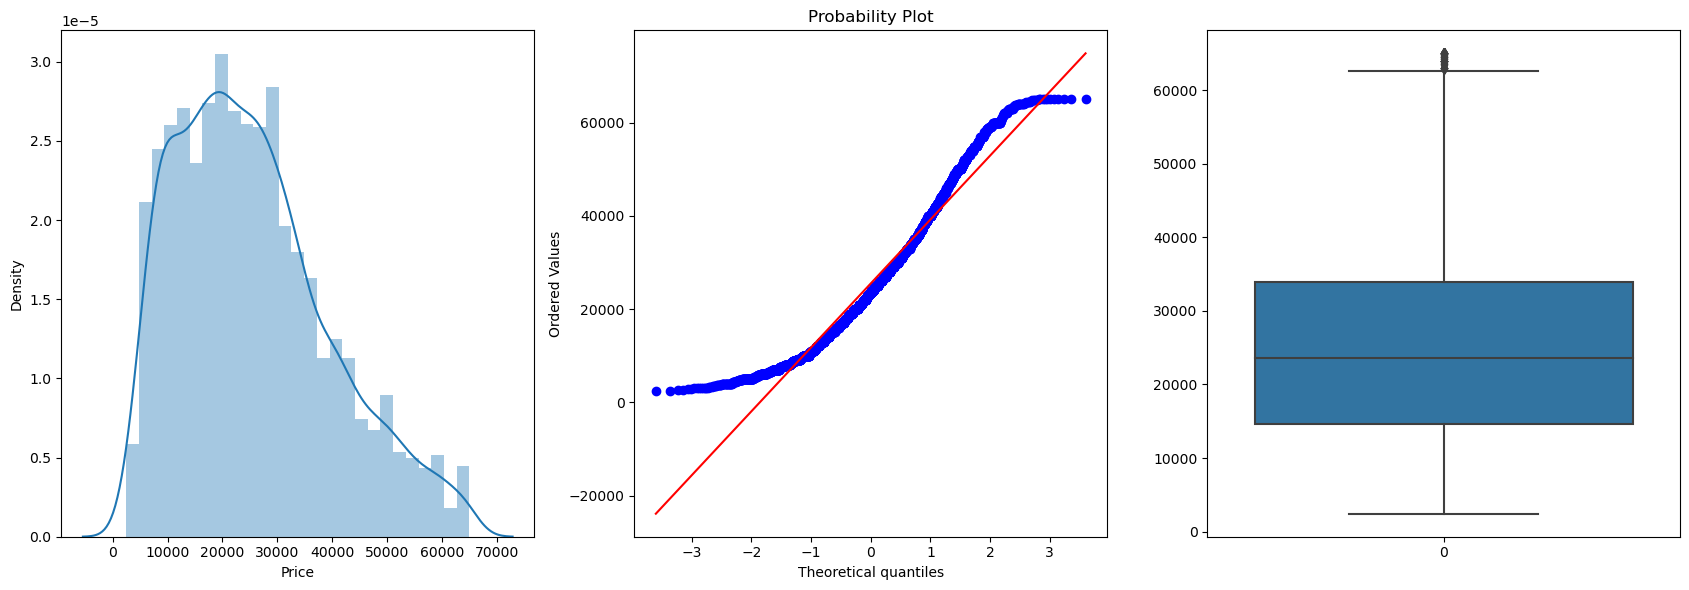

count     4350.000000
mean     25494.898851
std      14020.109392
min       2432.000000
25%      14689.750000
50%      23546.000000
75%      33900.000000
max      65000.000000
Name: Price, dtype: float64 

Skewness: 0.669625
Kurtosis: -0.139975


In [199]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["Price"])

plt.subplot(132)
stats.probplot(train["Price"], plot=plt)

plt.subplot(133)
sns.boxplot(train["Price"])
plt.tight_layout()
plt.show()

print(train["Price"].describe(),"\n")

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

In [201]:
print("Skewness: %f" % nomalized_Price.skew())
print("Kurtosis: %f" % nomalized_Price.kurt())

Skewness: -0.573412
Kurtosis: -0.119352


In [202]:
train.columns

Index(['Year', 'Brand', 'Model', 'Mileage', 'Bodystyle', 'Dealer',
       'Exterior Color', 'Interior Color', 'Drivetrain', 'MPG', 'Fuel Type',
       'Transmission', 'Engine', 'Price'],
      dtype='object')

In [203]:
train

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2021,volkswagen,tiguan,23626,suv,carmaxjensenbeachofferingexpresspickupandhomed...,platinumgraymetallic,black,front-wheel,23–29,gasoline,8-speed automatic,2.0l,23998
1,2023,toyota,prius,2947,hatchback,cowboydodgechryslerjeepram,silver,lightgray,front-wheel,57–56,gasoline,variable,2l,33217
2,2017,hyundai,accent,97675,sedan,freedomautosales,centurywhite,beige,front-wheel,26–36,gasoline,6-speed automatic,1.6l,9497
3,2016,dodge,dart,107671,sedan,caroneauto,blue,gray,front-wheel,25–36,gasoline,6-speed automatic,2.0l,6941
5,2021,lexus,gx_460,61418,suv,mercedesbenzofstatecollege,nightfallmica,black,four-wheel,15–19,gasoline,automatic,4.6l,37999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,2023,gmc,terrain,20267,suv,allamericanchryslerdodgejeepramofmidland,ebonytwilightmetallic,jetblack,all-wheel,24–28,gasoline,9-speed automatic,1.5l,27931
4894,2021,bmw,m235_gran_coupe,38704,sedan,donthorntonvolkswagenoftulsa,mineralgraymetallic,mocha,all-wheel,23–32,gasoline,8-speed automatic,2.0l,33362
4895,2017,mazda,mx_5_miata,76051,convertible,taylorautosalesinc,soulredmetallic,46730,rear-wheel,26–35,gasoline,manual,skyactiv-g,18995
4896,2015,buick,lacrosse,134401,sedan,mattbowersnissaneasternshore,champagnesilver,lightneutral,front-wheel,18–28,e85 flex fuel,6-speed automatic,3.6l,12497


In [204]:
# Divide into numeric and categorical variables
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [205]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 3 

Numerical Features :  ['Year', 'Mileage', 'Price'] 


Categorical Features Qty : 11 

Categorical Features : ['Brand', 'Model', 'Bodystyle', 'Dealer', 'Exterior Color', 'Interior Color', 'Drivetrain', 'MPG', 'Fuel Type', 'Transmission', 'Engine']


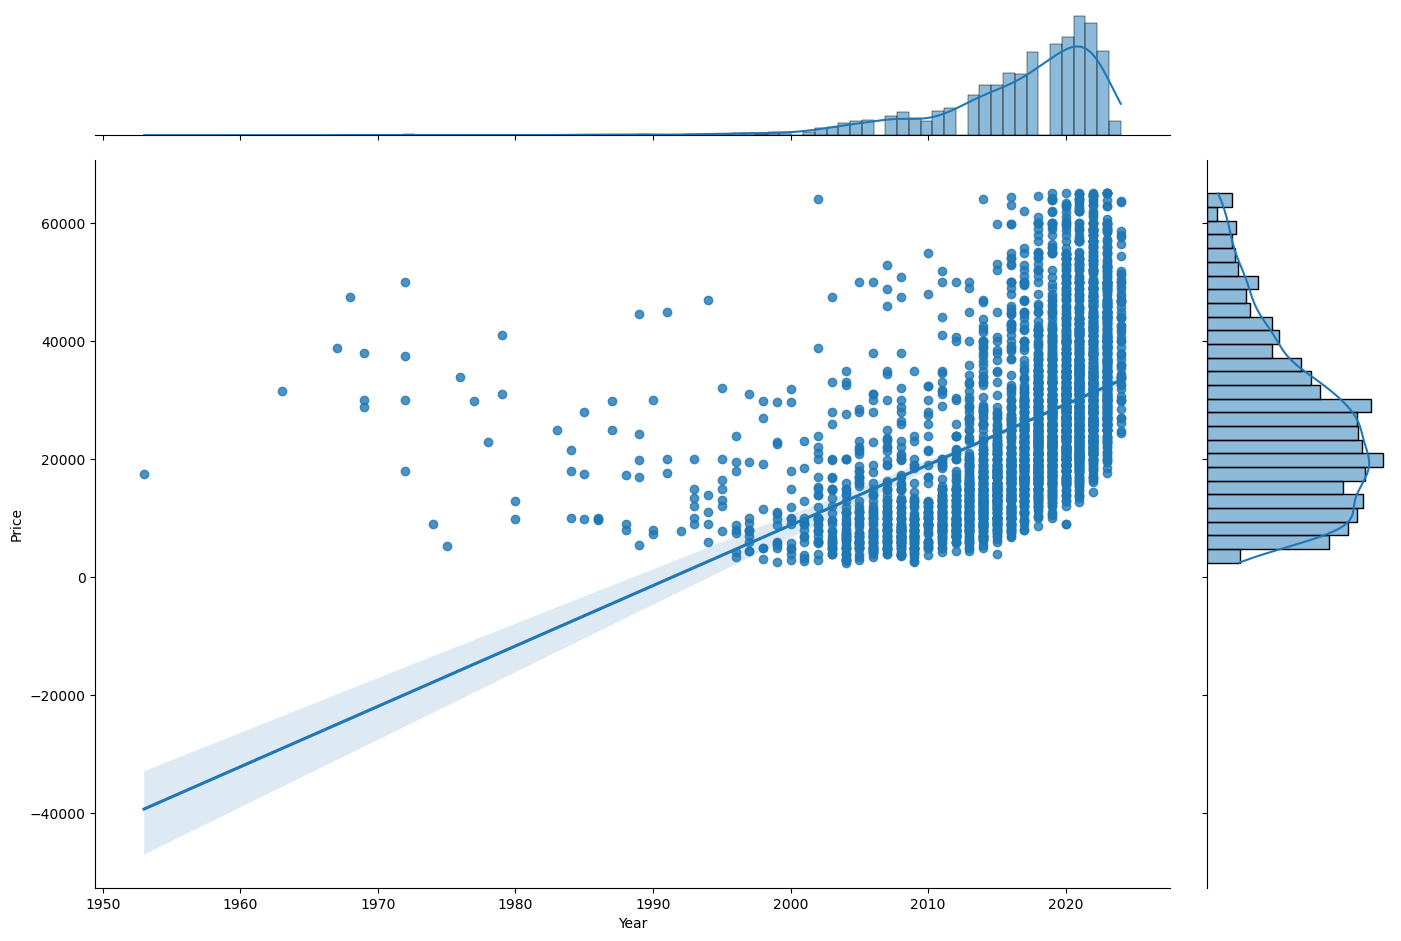

In [206]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Year", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

In [207]:
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]
sorted_filtered_data = filtered_data.sort_values(by='Year', ascending=True).reset_index(drop=True)
sorted_filtered_data



,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price


In [208]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]

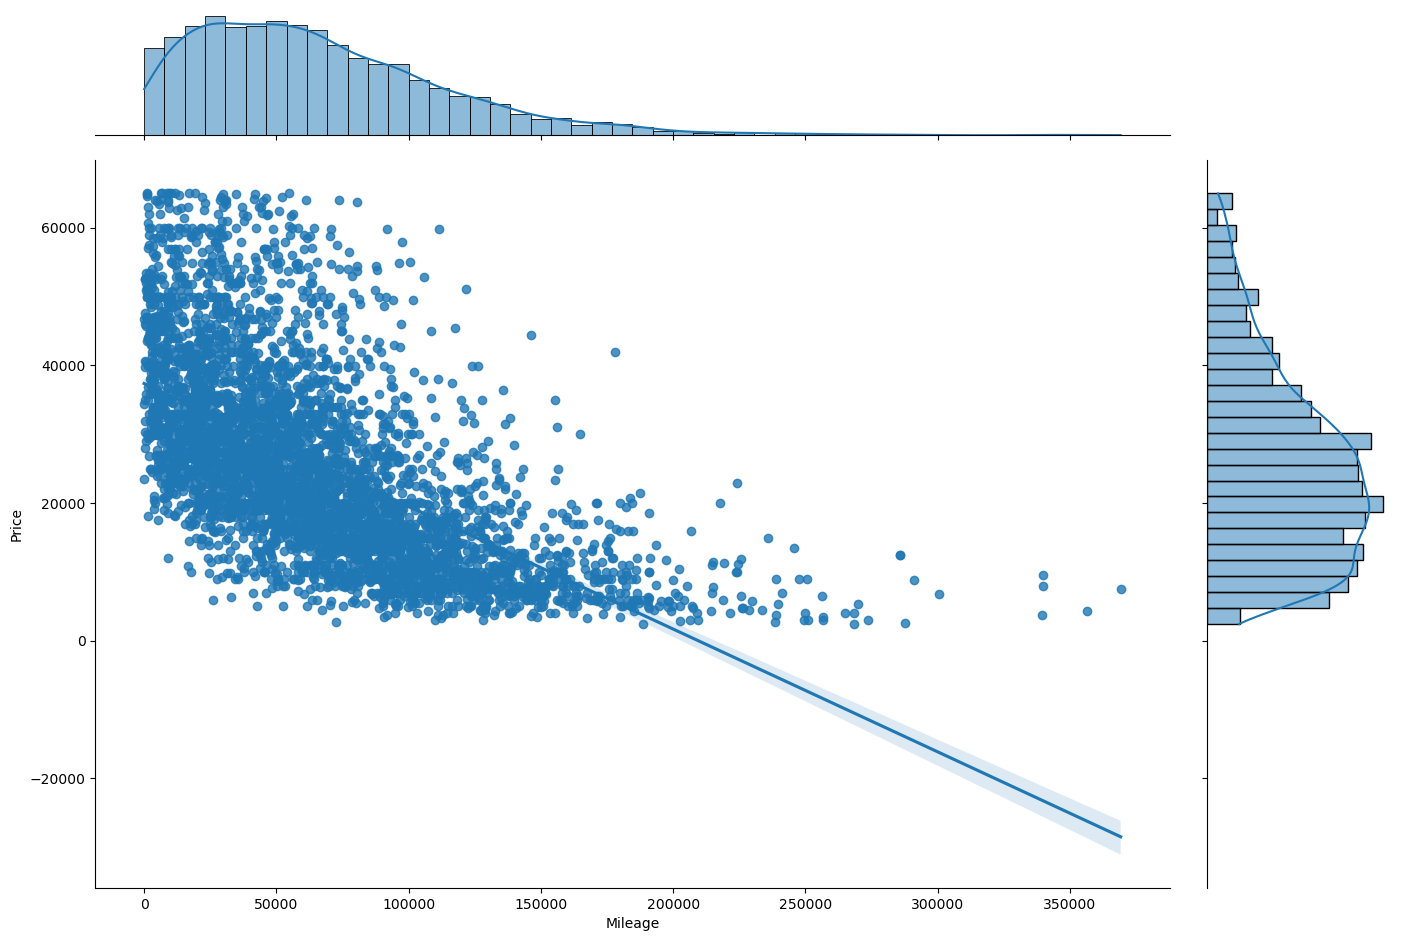

In [209]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Mileage", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

In [210]:
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]
sorted_filtered_data = filtered_data.sort_values(by='Mileage', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price


In [211]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]

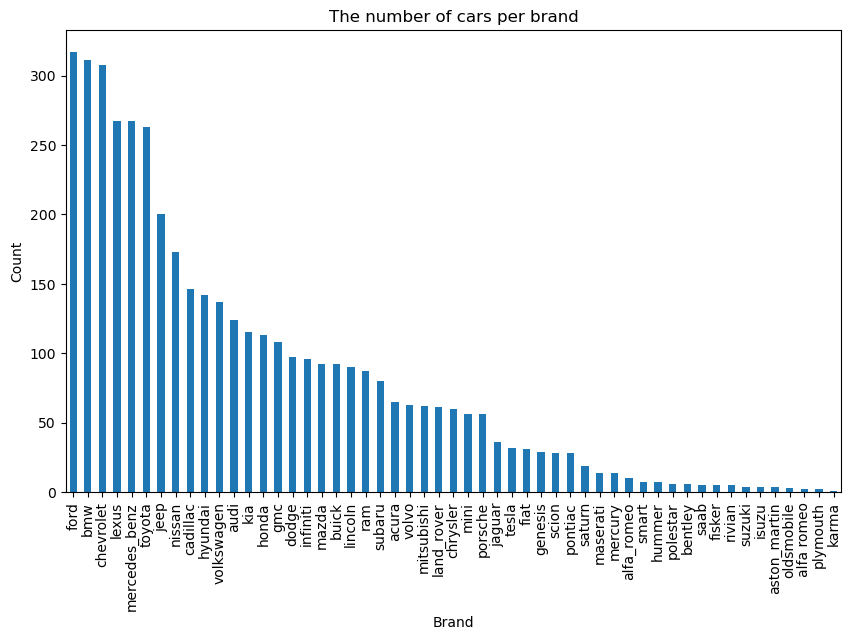

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

# train 데이터에서 각 브랜드별로 총 수를 집계
brand_counts = train['Brand'].value_counts()

# 그래프를 그리기 위해 가장 많은 순서대로 정렬
brand_counts_sorted = brand_counts.sort_values(ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
brand_counts_sorted.plot(kind='bar')
plt.title('The number of cars per brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


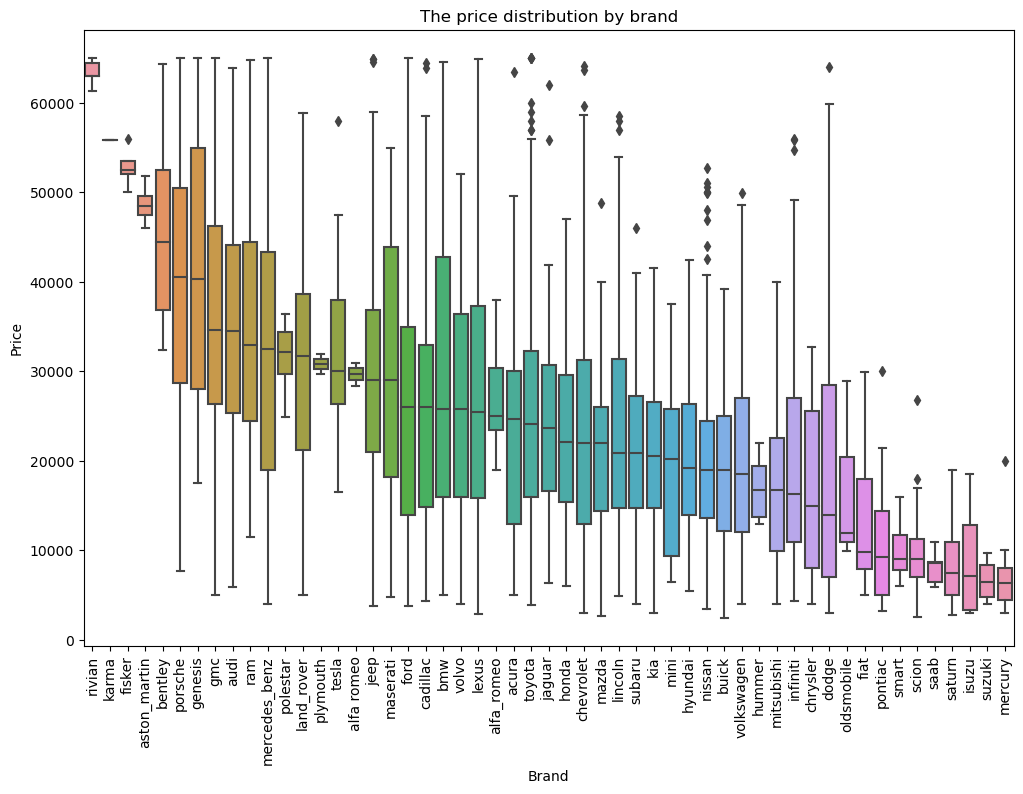

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

# 가격 분포가 높은 순으로 브랜드 정렬
sorted_brands = train.groupby('Brand')['Price'].median().sort_values(ascending=False).index

# 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='Brand', y='Price', data=train, order=sorted_brands)
plt.title('The price distribution by brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


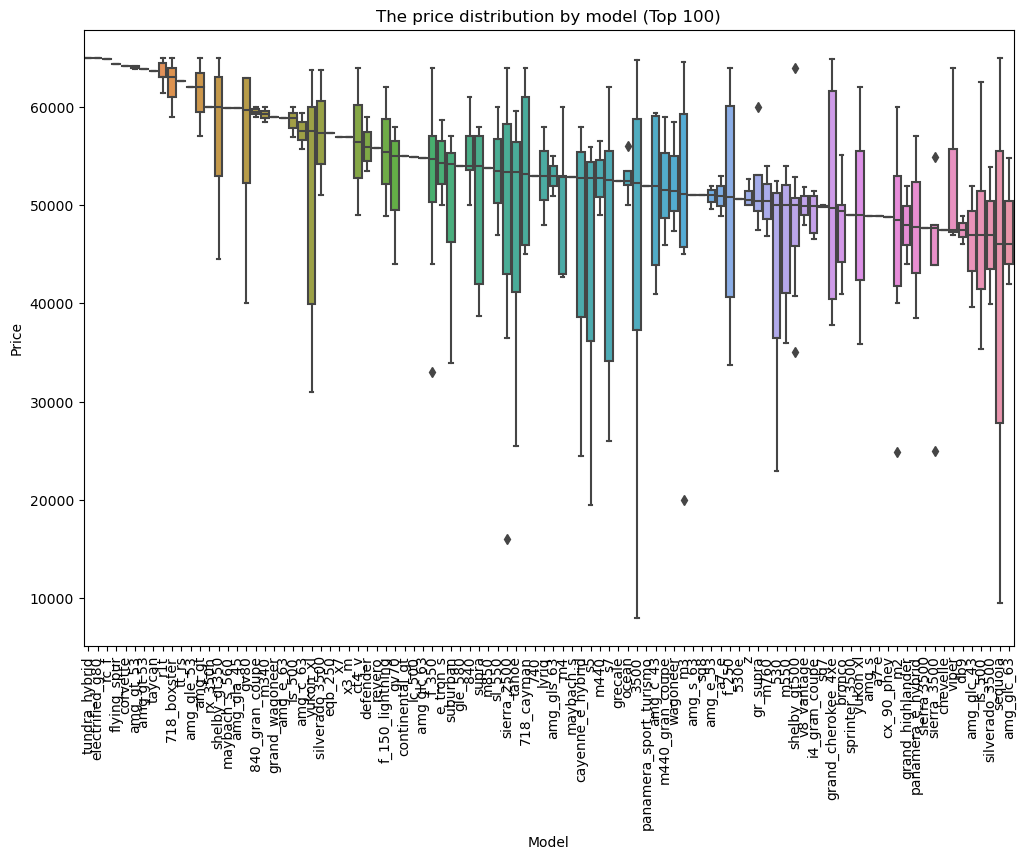

In [214]:

# 가격이 높은 순으로 모델 정렬
sorted_models = train.groupby('Model')['Price'].median().sort_values(ascending=False).head(100).index

# 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='Price', data=train, order=sorted_models)
plt.title('The price distribution by model (Top 100)')
plt.xlabel('Model')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [215]:
# Select models and brands as category variables
categorical_features = ['Brand', 'Model', 'Bodystyle', 'Exterior Color', 'Interior Color', 'Drivetrain',\
                            'MPG','Fuel Type', 'Transmission','Engine']

# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,Brand_cadillac,Brand_chevrolet,...,Engine_twin,Engine_v6,"Engine_v6,",Engine_v8,"Engine_v8,",Engine_vc-turbo,Engine_vortec,Engine_vq,Engine_vr,Engine_–
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [216]:
# Select by numeric variable
numerical_features = ['Year', 'Mileage', 'Price']
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,Year,Mileage,Price
0,7.611842,10.070145,10.085767
1,7.612831,7.988882,10.410847
2,7.609862,11.489411,9.158837
3,7.609367,11.586845,8.845345
5,7.611842,11.025475,10.545341


In [217]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["Price"]
X_train = X_train_0.drop("Price", axis=1)

In [218]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [219]:
# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [220]:
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [221]:
special_columns = [col for col in X_train1.columns if any(char in col for char in ['[', ']', '<'])]

print("컬럼 이름에 [, ], < 가 포함된 컬럼:", special_columns)



컬럼 이름에 [, ], < 가 포함된 컬럼: []


In [222]:
# Check the corss validation score
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))

KeyboardInterrupt: 

NameError: name 'score' is not defined

In [40]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBRegressor
import numpy as np

In [42]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBRegressor
import numpy as np

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Create XGBRegressor with required parameters
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

# Fit the model with training data
ml.fit(X_train, y_train)

# Check the corss validation score
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))


ValueError: feature_names must be string, and may not contain [, ] or <